In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Setup de rutas del dataset

In [8]:
# imports
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation

# Helper para mostrar estructura de carpetas
def showDatasetStructure(baseDir):
    print("Estructura de carpetas del dataset:")
    for subset in ["train", "val", "test"]:
        path = os.path.join(baseDir, subset)
        print(f"\n{subset.upper()} -> {os.listdir(path)}")
        print(f"Total de imágenes en {subset}:")
        for cls in os.listdir(path):
            clsPath = os.path.join(path, cls)
            print(f"  {cls}: {len(os.listdir(clsPath))}")

# Main
def main():
    print("Configurando entorno en Kaggle...")
    baseDir = "/kaggle/input/chest-xray-pneumonia/chest_xray"

    # Verificar si existe la ruta base
    if not os.path.exists(baseDir):
        print("No se encontró el dataset. Asegúrate de agregarlo como input dataset.")
        return

    # Mostrar estructura general del dataset
    showDatasetStructure(baseDir)
    print("\nConfiguración completada correctamente.")

if __name__ == "__main__":
    main()

Configurando entorno en Kaggle...
Estructura de carpetas del dataset:

TRAIN -> ['PNEUMONIA', 'NORMAL']
Total de imágenes en train:
  PNEUMONIA: 3875
  NORMAL: 1341

VAL -> ['PNEUMONIA', 'NORMAL']
Total de imágenes en val:
  PNEUMONIA: 8
  NORMAL: 8

TEST -> ['PNEUMONIA', 'NORMAL']
Total de imágenes en test:
  PNEUMONIA: 390
  NORMAL: 234

Configuración completada correctamente.


# Procesamiento de imagenes

Preparando generadores de datos...
Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Generadores creados correctamente.


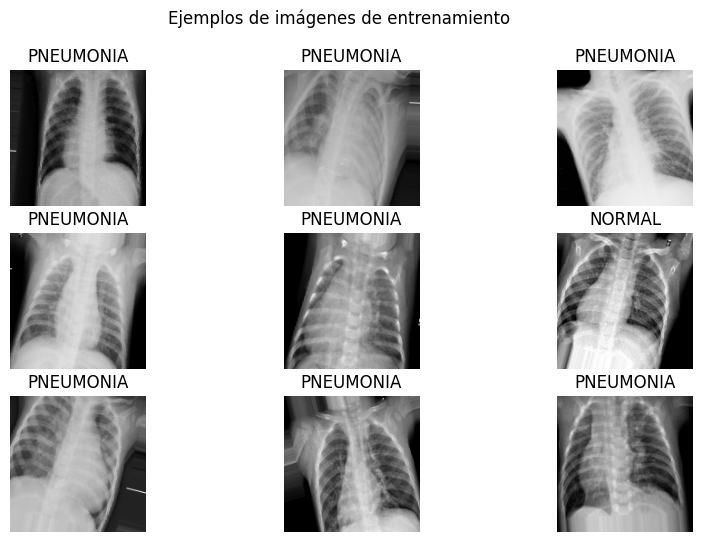

Clases detectadas: {'NORMAL': 0, 'PNEUMONIA': 1}


In [9]:
# Helper function: crea generadores de datos
def createDataGenerators(baseDir, imgSize=(150, 150), batchSize=32):
    # Aumentos para entrenamiento
    trainAug = ImageDataGenerator(
        rescale=1./255,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True
    )

    # Validación y test: solo normalización
    testAug = ImageDataGenerator(rescale=1./255)

    # Crear generadores desde carpetas
    trainGen = trainAug.flow_from_directory(
        os.path.join(baseDir, "train"),
        target_size=imgSize,
        batch_size=batchSize,
        class_mode='binary'
    )

    valGen = testAug.flow_from_directory(
        os.path.join(baseDir, "val"),
        target_size=imgSize,
        batch_size=batchSize,
        class_mode='binary'
    )

    testGen = testAug.flow_from_directory(
        os.path.join(baseDir, "test"),
        target_size=imgSize,
        batch_size=batchSize,
        class_mode='binary',
        shuffle=False
    )

    return trainGen, valGen, testGen

# Helper function: muestra ejemplos del generador
def showSampleImages(generator):
    imgs, labels = next(generator)
    plt.figure(figsize=(10, 6))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(imgs[i])
        plt.title("PNEUMONIA" if labels[i] == 1 else "NORMAL")
        plt.axis("off")
    plt.suptitle("Ejemplos de imágenes de entrenamiento")
    plt.show()

# Main
def main():
    print("Preparando generadores de datos...")
    baseDir = "/kaggle/input/chest-xray-pneumonia/chest_xray"

    trainGen, valGen, testGen = createDataGenerators(baseDir)
    print("Generadores creados correctamente.")

    # Mostrar ejemplos del conjunto de entrenamiento
    showSampleImages(trainGen)

    # Mostrar clases detectadas
    print("Clases detectadas:", trainGen.class_indices)

if __name__ == "__main__":
    main()

# Definicion del modelo CNN

In [14]:
# Funcion de construccion del modelo
def buildModel(inputShape=(150, 150, 3)):
    model = Sequential()

    # Bloque 1
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=inputShape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Bloque 2
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Bloque 3
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Clasificador
    model.add(Flatten())
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1, activation='sigmoid'))

    return model

# Compilador del modelo
def compileModel(model, lr=1e-3):
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Main
def main():
    print("Construyendo modelo CNN...")
    model = buildModel()
    model = compileModel(model)
    model.summary()

if __name__ == "__main__":
    main()

Construyendo modelo CNN...


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 150, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     5,308,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,403,329 (20.61 MB)

 Trainable params: 5,402,625 (20.61 MB)

 Non-trainable params: 704 (2.75 KB)